In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3969


In [13]:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.01, betas=(.9, .999), weight_decay=0),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=50,
    patience=5,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:01<00:00, 569.86it/s]


Epoch   1/200: RMSE_train: 1,732,956, RMSE_val: 1,728,501


100%|██████████| 646/646 [00:01<00:00, 598.40it/s]


Epoch   2/200: RMSE_train: 1,724,407, RMSE_val: 1,716,364


100%|██████████| 646/646 [00:01<00:00, 586.84it/s]


Epoch   3/200: RMSE_train: 1,708,978, RMSE_val: 1,703,259


100%|██████████| 646/646 [00:01<00:00, 615.93it/s]


Epoch   4/200: RMSE_train: 1,687,267, RMSE_val: 1,681,593


100%|██████████| 646/646 [00:01<00:00, 617.43it/s]


Epoch   5/200: RMSE_train: 1,661,199, RMSE_val: 1,663,979


100%|██████████| 646/646 [00:01<00:00, 594.62it/s]


Epoch   6/200: RMSE_train: 1,630,352, RMSE_val: 1,640,829


100%|██████████| 646/646 [00:01<00:00, 600.03it/s]


Epoch   7/200: RMSE_train: 1,595,767, RMSE_val: 1,608,485


100%|██████████| 646/646 [00:01<00:00, 620.34it/s]


Epoch   8/200: RMSE_train: 1,557,521, RMSE_val: 1,594,860


100%|██████████| 646/646 [00:01<00:00, 587.35it/s]


Epoch   9/200: RMSE_train: 1,516,690, RMSE_val: 1,570,476


100%|██████████| 646/646 [00:01<00:00, 620.25it/s]


Epoch  10/200: RMSE_train: 1,471,993, RMSE_val: 1,546,425


100%|██████████| 646/646 [00:01<00:00, 598.25it/s]


Epoch  11/200: RMSE_train: 1,424,574, RMSE_val: 1,500,675


100%|██████████| 646/646 [00:01<00:00, 603.07it/s]


Epoch  12/200: RMSE_train: 1,375,047, RMSE_val: 1,475,375


100%|██████████| 646/646 [00:01<00:00, 594.41it/s]


Epoch  13/200: RMSE_train: 1,321,810, RMSE_val: 1,436,000


100%|██████████| 646/646 [00:01<00:00, 616.10it/s]


Epoch  14/200: RMSE_train: 1,268,781, RMSE_val: 1,409,969


100%|██████████| 646/646 [00:01<00:00, 597.86it/s]


Epoch  15/200: RMSE_train: 1,212,351, RMSE_val: 1,373,096


100%|██████████| 646/646 [00:01<00:00, 616.30it/s]


Epoch  16/200: RMSE_train: 1,154,191, RMSE_val: 1,359,634


100%|██████████| 646/646 [00:01<00:00, 604.38it/s]


Epoch  17/200: RMSE_train: 1,095,568, RMSE_val: 1,306,809


100%|██████████| 646/646 [00:01<00:00, 615.63it/s]


Epoch  18/200: RMSE_train: 1,037,734, RMSE_val: 1,233,676


100%|██████████| 646/646 [00:01<00:00, 600.61it/s]


Epoch  19/200: RMSE_train: 978,257, RMSE_val: 1,240,130
EarlyStopping counter: 1 out of 10


100%|██████████| 646/646 [00:01<00:00, 622.62it/s]


Epoch  20/200: RMSE_train: 917,661, RMSE_val: 1,193,313


100%|██████████| 646/646 [00:01<00:00, 615.59it/s]


Epoch  21/200: RMSE_train: 862,048, RMSE_val: 1,152,000


100%|██████████| 646/646 [00:01<00:00, 620.24it/s]


Epoch  22/200: RMSE_train: 810,064, RMSE_val: 1,129,299


100%|██████████| 646/646 [00:01<00:00, 602.51it/s]


Epoch  23/200: RMSE_train: 759,780, RMSE_val: 1,106,313


100%|██████████| 646/646 [00:01<00:00, 617.56it/s]


Epoch  24/200: RMSE_train: 713,815, RMSE_val: 1,086,943


100%|██████████| 646/646 [00:01<00:00, 622.09it/s]


Epoch  25/200: RMSE_train: 670,741, RMSE_val: 1,083,159


100%|██████████| 646/646 [00:01<00:00, 613.12it/s]


Epoch  26/200: RMSE_train: 642,454, RMSE_val: 1,035,509


100%|██████████| 646/646 [00:01<00:00, 598.60it/s]


Epoch  27/200: RMSE_train: 612,067, RMSE_val: 1,045,907
EarlyStopping counter: 1 out of 10


100%|██████████| 646/646 [00:01<00:00, 620.14it/s]


Epoch  28/200: RMSE_train: 600,994, RMSE_val: 1,013,991


100%|██████████| 646/646 [00:01<00:00, 618.55it/s]


Epoch  29/200: RMSE_train: 581,347, RMSE_val: 1,038,748
EarlyStopping counter: 1 out of 10


100%|██████████| 646/646 [00:01<00:00, 601.11it/s]


Epoch  30/200: RMSE_train: 570,375, RMSE_val: 1,035,552
EarlyStopping counter: 2 out of 10


100%|██████████| 646/646 [00:01<00:00, 617.79it/s]


Epoch  31/200: RMSE_train: 563,977, RMSE_val: 1,056,893
EarlyStopping counter: 3 out of 10


100%|██████████| 646/646 [00:01<00:00, 617.75it/s]


Epoch  32/200: RMSE_train: 560,038, RMSE_val: 1,014,178
EarlyStopping counter: 4 out of 10


100%|██████████| 646/646 [00:01<00:00, 616.66it/s]


Epoch  33/200: RMSE_train: 549,480, RMSE_val: 1,039,128
EarlyStopping counter: 5 out of 10


100%|██████████| 646/646 [00:01<00:00, 602.02it/s]


Epoch  34/200: RMSE_train: 558,928, RMSE_val: 989,165


100%|██████████| 646/646 [00:01<00:00, 618.93it/s]


Epoch  35/200: RMSE_train: 548,868, RMSE_val: 1,007,622
EarlyStopping counter: 1 out of 10


100%|██████████| 646/646 [00:01<00:00, 626.51it/s]


Epoch  36/200: RMSE_train: 550,522, RMSE_val: 989,864
EarlyStopping counter: 2 out of 10


100%|██████████| 646/646 [00:01<00:00, 614.62it/s]


Epoch  37/200: RMSE_train: 555,277, RMSE_val: 1,015,685
EarlyStopping counter: 3 out of 10


100%|██████████| 646/646 [00:01<00:00, 595.29it/s]


Epoch  38/200: RMSE_train: 546,399, RMSE_val: 1,018,401
EarlyStopping counter: 4 out of 10


100%|██████████| 646/646 [00:01<00:00, 614.63it/s]


Epoch  39/200: RMSE_train: 544,714, RMSE_val: 942,459


100%|██████████| 646/646 [00:01<00:00, 620.37it/s]


Epoch  40/200: RMSE_train: 541,817, RMSE_val: 1,022,603
EarlyStopping counter: 1 out of 10


100%|██████████| 646/646 [00:01<00:00, 613.92it/s]


Epoch  41/200: RMSE_train: 546,645, RMSE_val: 1,028,019
EarlyStopping counter: 2 out of 10


100%|██████████| 646/646 [00:01<00:00, 618.72it/s]


Epoch  42/200: RMSE_train: 539,340, RMSE_val: 975,602
EarlyStopping counter: 3 out of 10


100%|██████████| 646/646 [00:01<00:00, 618.72it/s]


Epoch  43/200: RMSE_train: 538,886, RMSE_val: 1,019,950
EarlyStopping counter: 4 out of 10


100%|██████████| 646/646 [00:01<00:00, 617.02it/s]


Epoch  44/200: RMSE_train: 541,122, RMSE_val: 1,037,962
EarlyStopping counter: 5 out of 10


100%|██████████| 646/646 [00:01<00:00, 598.20it/s]


Epoch  45/200: RMSE_train: 530,921, RMSE_val: 1,021,597
EarlyStopping counter: 6 out of 10


100%|██████████| 646/646 [00:01<00:00, 618.39it/s]


Epoch  46/200: RMSE_train: 537,594, RMSE_val: 1,023,759
EarlyStopping counter: 7 out of 10


100%|██████████| 646/646 [00:01<00:00, 615.82it/s]


Epoch  47/200: RMSE_train: 534,637, RMSE_val: 1,011,611
EarlyStopping counter: 8 out of 10


100%|██████████| 646/646 [00:01<00:00, 616.28it/s]


Epoch  48/200: RMSE_train: 532,158, RMSE_val: 1,024,598
EarlyStopping counter: 9 out of 10


100%|██████████| 646/646 [00:01<00:00, 606.69it/s]

Epoch  49/200: RMSE_train: 533,355, RMSE_val: 1,020,625
EarlyStopping counter: 10 out of 10
Early stopping condition met


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   589056.617  320673.530  0.471  0.777
val     943847.957  589837.511  0.902  0.419
test    984426.142  598261.595  0.872  0.374
--------------------------------------------
total   725112.141  403103.866  0.594  0.662


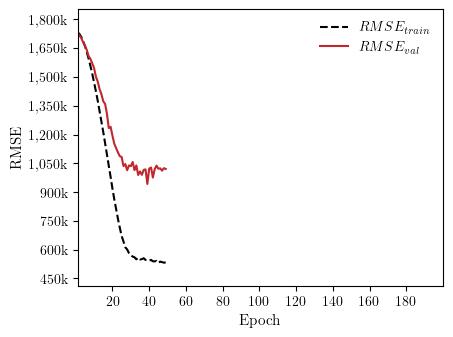

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

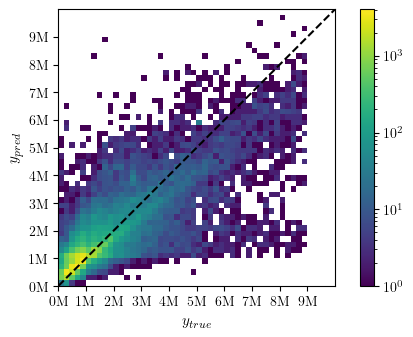

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')